# Prediccion del indice S&P 500 mediante XGBOOST y el modelo GARCH

El inidice S&P 500 de la bolsa de valores de nueva york es uno de los indices mas importantes en el munod, ya que reune las 500 principales empresas de la economia estadounidense, por lo tanto este indice muestra como puede estar la eocnomia en uno de los paises mas importantes en la actualidad o el mas importantes a niveles economicos. por lo tanto mediante 2 metodos de prediccion como el XGBOOST y el modelo GARCH se haran predicciones de los retornos de esta inversion.

* ¿Porque se estiman los retornos del activo y no los valores absolutos de la serie de timepo?

Primero hay que explicar los retornos, los cuales son a las ganancias o pérdidas generadas por una inversión durante un período de tiempo específico. Representan el rendimiento financiero obtenido por un operador o inversor en relación con la cantidad de dinero que se ha invertido.

Entonces porque se usan estos en la prediccion , por varios motivos como:

1. Al modelar la tasa de retorno en lugar de los valores absolutos, se pueden comparar y analizar diferentes instrumentos financieros o activos de manera más efectiva. Las tasas de retorno proporcionan una medida relativa de desempeño entre diferentes inversiones, lo que permite evaluar qué activos tienen un mejor rendimiento relativo y tomar decisiones de inversión basadas en esa información.
2. Al modelar las tasas de retorno, se tiende a eliminar o reducir las tendencias generales en los datos, lo que permite identificar patrones o comportamientos específicos que pueden ser más relevantes para la toma de decisiones financieras
3. Las tasas de retorno suelen ser más estacionarias que los valores absolutos en las series de tiempo financieras. La estacionariedad implica que las propiedades estadísticas de una serie, como la media y la varianza, no cambian con el tiempo


# Librerias

In [110]:
# base
import pandas as pd
import numpy as np
import math
import datetime
import datetime as dt
import statsmodels.api as sms
from itertools import product


# importacion datos financieros
import yfinance as yf

#metricas de evaluacion 

from arch.unitroot import PhillipsPerron , KPSS , ADF
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error

# Graficas
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns


# Prediccion modelos GARCH
from pmdarima import auto_arima
import arch
from arch import arch_model

# Prediccion modelo XGBOOST
import xgboost as xgb


# Lectura de datos

Con la libreria yahoo finance se traeran los valores diarios del indice S&P500 desde el 2021-01-01 hasta el 2023-10-15

In [38]:
data = yf.download(tickers = '^GSPC',start='2021-01-01',end='2023-10-05',interval='1d')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5015000000
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4591020000
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6064110000
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5099160000
2021-01-08,3815.050049,3826.689941,3783.600098,3824.679932,3824.679932,4773040000


In [39]:
data = data.rename(columns=str.lower)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 597 entries, 2021-01-04 to 2023-05-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       597 non-null    float64
 1   high       597 non-null    float64
 2   low        597 non-null    float64
 3   close      597 non-null    float64
 4   adj close  597 non-null    float64
 5   volume     597 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 32.6 KB


In [40]:
data['time'] = data.index

In [41]:
retornos = data[['close']].pct_change().dropna() * 100
retornos.head()

,close
Date,
2021-01-05,0.708260
2021-01-06,0.570984
2021-01-07,1.484740
2021-01-08,0.549186
2021-01-11,-0.655475


In [42]:
# media rendimientos diarios
retornos.mean()

close    0.026634
dtype: float64

In [43]:
# grafica de los retornos
close_price = retornos
rendimiento_acum_dia = close_price/close_price.iloc[0,:]
fig = px.line(rendimiento_acum_dia.iloc[:,:])
fig.update_layout(title_text='Redimiento acumulado diario S&P 500')
fig.show()

In [44]:
# volatilidad diaria
daily_volatility = retornos.values.std()
daily_volatility

1.1867987576811718

In [45]:
monthly_volatility = math.sqrt(21)*daily_volatility # 21 porque hay 21 dias habiles en el mes
monthly_volatility

5.438595141753523

<AxesSubplot:title={'center':'Rtornos diarios'}, xlabel='Date'>

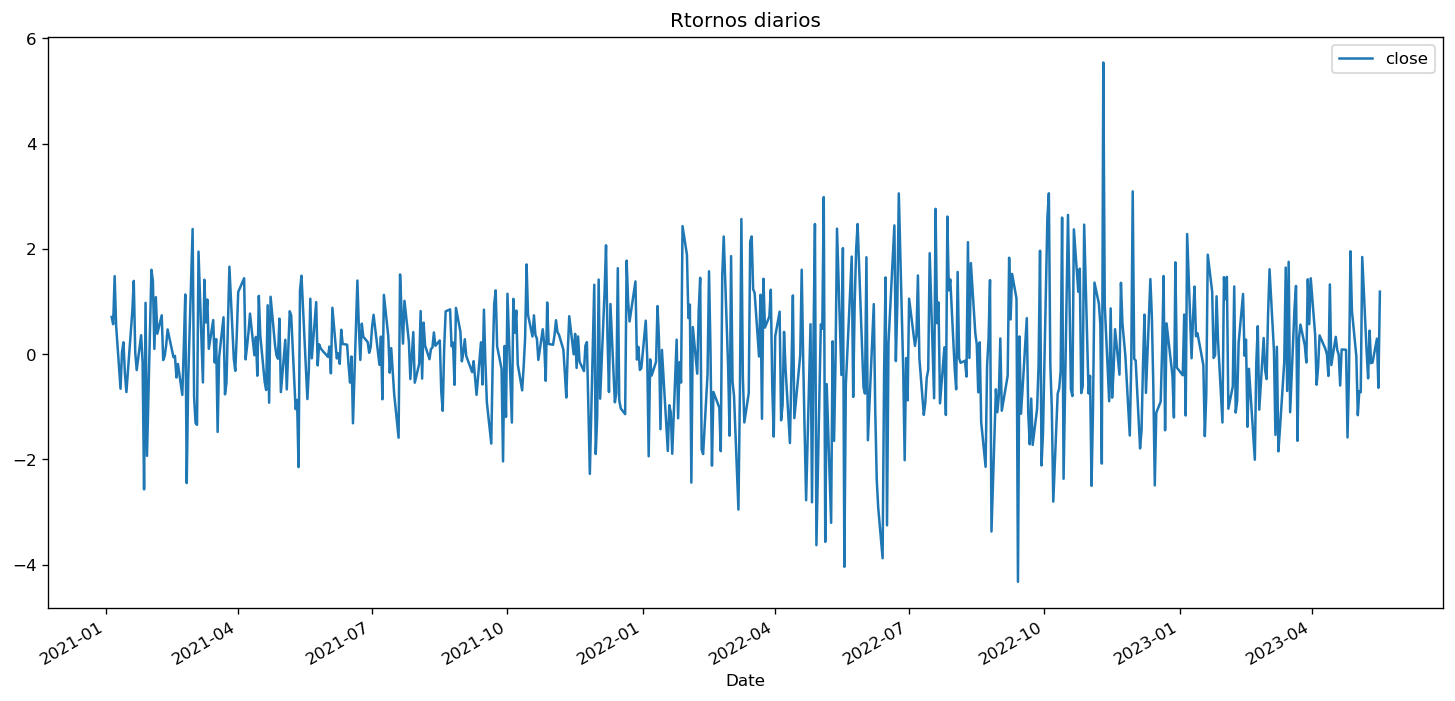

In [46]:
# retornos diarios sin acumulado
retornos.plot(figsize=(15,7),title='Rtornos diarios')

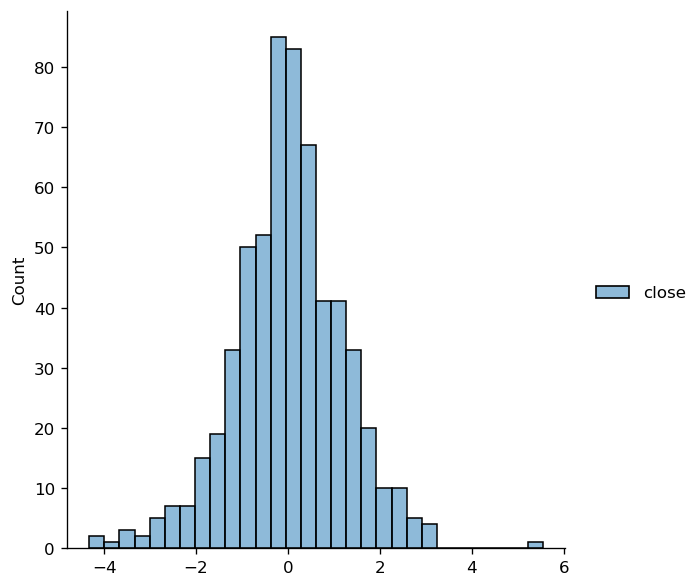

In [47]:
sns.displot(retornos)

# Modelo GARCH 

En muchas series, como por ejemplo en las financieras, el numero de retardos a utilizar es muy elevado, lo cual dificulta su estimacion. Es por esto, que Bollerslev(1986) propone un modelo en el cual la varianza condicional no solo depende de los cuadrados de los errores, como en el modelo ARCH, sino que ademas depende de las varianzas condicionales de periodos anteriores.

## Estacionariedad

Se buscara si los retornos del activo son estacionarios, ya que esto es un supuesto escencial a la hora de aplicar el modelo GARCH, en caso de no ser estacionario se debera de hacer un tratamiento como la diferenciacion con el fin de buscar la estacionariedad

### Grafica de los retornos

In [91]:
fig = px.line(rendimiento_acum_dia.iloc[:,:])
fig.update_layout(title_text='Redimiento acumulado diario S&P 500')
fig.show()

Un primer indicativo es la grafica de la variable. De esta grafica podemos decir varias cosas como:

* Se puede ver que no tiene tendencias
* Se observa que tiene media constante alrededor de 0
* Tambien parece tener varianza constante a lo largo del timepo

Estos son buenos indicativos ya que hacen cumplir los supuestos del modelo

### Test de estacionariedad
* ADF :

$H_0$ = El proceso contiene raiz unitaria

$H_1$ = El proceso es debilmente estacionario

* PP:

$H_0$ = El proceso contiene raiz unitaria

$H_1$ = El proceso es debilmente estacionario

* KPSS :

$H_0$ = El proceso es debilmente estacionario

$H_1$ = El proceso contiene raiz unitaria

In [48]:
def Estacionariedad(data):
  """
  Realiza el test ADF, PP, KPSS sobre una serie de tiempo indicada en df 
  y una columna en especifico indicada en pais
  """
  adf_pvalue = round(ADF(data).pvalue, 6)
  pp_pvalue = round(PhillipsPerron(data).pvalue, 6)
  kpss_pvalue = round(KPSS(data).pvalue, 6)
  
  results = {'ADF': [adf_pvalue], 'PP': [pp_pvalue], 'KPSS': [kpss_pvalue]}
  df_tests = pd.DataFrame(results)
  
  return df_tests


In [49]:
Estacionariedad(retornos)

,ADF,PP,KPSS
0,0.0,0.0,0.43737


como p-valor < $\alpha$ se rechaza $H_o$ para el test ADF Y PP y se acepta KPSS. No parece haber reiz unitaria en los retornos del activo , por lo tanto podmeos decir que los retornos son estacionarios 

## Grafica ACF y PACF

Otra forma de ver estacionariedad en los modelos es mediante las graficas ACF y PACF , ya que si los rezagos de la serie convergen rapidamente al intervalo, podemos decir que son estacionarios

c:\Users\Juan Guzman\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



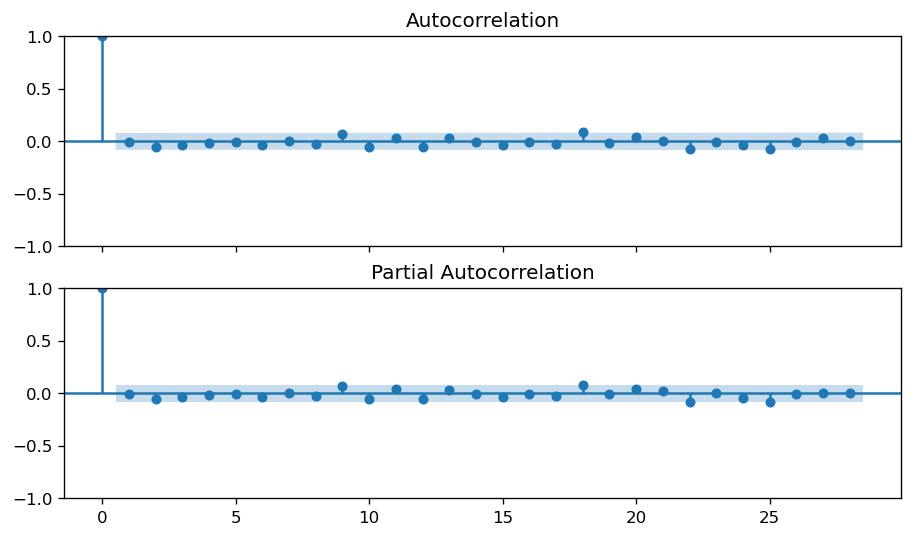

In [50]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})

fig, axes = plt.subplots(2, 1, sharex=True)

plot_acf(retornos,ax=axes[0])
plot_pacf(retornos,ax=axes[1])
plt.show()

Se observa que converge rapidamente

## Estimacion modelo

Se iniciara con la estimacion del modelo GARCH. 
Para determianr los valores de p,o,q se hara una simulacion de cross validation aunqeu no muy perfecta

Donde:
* p = Orden de retardo de la innovación simétrica
* o = Orden de retardo de la innovación asimétrica
* q = Orden de retraso de la volatilidad retrasada o equivalente

In [111]:
p = [1, 2, 3, 4, 5]
o = [1, 2, 3, 4, 5]
q = [1, 2, 3, 4, 5]

data = []
combinations = product(p, o, q)

for combination in combinations:
    p_val, o_val, q_val = combination
    modelo = arch_model(retornos, dist='ged', vol='Garch', p=p_val, o=o_val, q=q_val)
    modelo_fit = modelo.fit(disp='off')
    aic = modelo_fit.aic
    bic = modelo_fit.bic
    data.append([p_val, o_val, q_val, aic, bic])

df = pd.DataFrame(data, columns=['p', 'o', 'q', 'AIC', 'BIC'])

df.head()

,p,o,q,AIC,BIC
0,1,1,1,1783.373330,1809.714774
1,1,1,2,1785.353250,1816.084935
2,1,1,3,1786.290447,1821.412372
3,1,1,4,1787.189743,1826.701909
4,1,1,5,1789.077520,1832.979926


In [112]:
min_idx_AIC = df['AIC'].idxmin() # el indice con el valor mínimo del AIC
min_idx_BIC = df['BIC'].idxmin() # el indice con el valor mínimo del BIC
min_value_AIC = df.loc[min_idx_AIC, 'AIC'] # valor minimo del AIC
min_value_BIC = df.loc[min_idx_BIC, 'BIC'] # valor minimo del BIC
row_AIC = df.loc[min_idx_AIC, :] # demas columnas del minimo del AIC
row_BIC = df.loc[min_idx_BIC, :] # demas columnas del minimo del BIC
# Imprime los resultados
print("Mínimo de A:", min_value_AIC)
print("Fila correspondiente a mínimo de A:\n", row_AIC)
print("Mínimo de B:", min_value_BIC)
print("Fila correspondiente a mínimo de B:\n", row_BIC)

Mínimo de A: 1783.3733298310972
Fila correspondiente a mínimo de A:
 p         1.000000
o         1.000000
q         1.000000
AIC    1783.373330
BIC    1809.714774
Name: 0, dtype: float64
Mínimo de B: 1809.7147738334893
Fila correspondiente a mínimo de B:
 p         1.000000
o         1.000000
q         1.000000
AIC    1783.373330
BIC    1809.714774
Name: 0, dtype: float64


Se puede observar que el modelo que muestra los mejores valores tanto para el criterio de informacion de akaike como el bayesiano se tiene GARCH(p=1,o=1,q=1)

In [113]:
# Modelo definitivo
model = arch_model(retornos,dist='ged', vol='Garch',p=1,o=1,q=1) # dist = Nombre de la distribución de errores. vol = Nombre del modelo de volatilidad
model_fit = model.fit(disp='off')
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - GJR-GARCH Model Results                          
==========================================================================================
Dep. Variable:                              close   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                              GJR-GARCH   Log-Likelihood:               -885.687
Distribution:      Generalized Error Distribution   AIC:                           1783.37
Method:                        Maximum Likelihood   BIC:                           1809.71
                                                    No. Observations:                  596
Date:                            Wed, May 17 2023   Df Residuals:                      595
Time:                                    17:31:22   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0343  3.945e-02      0.868      0.385 [-4.307e-02,  0.112]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0105  1.678e-02      0.626      0.531 [-2.238e-02,4.339e-02]
alpha[1]   2.9136e-10  5.979e-02  4.873e-09      1.000      [ -0.117,  0.117]
gamma[1]       0.1284  3.728e-02      3.445  5.718e-04    [5.535e-02,  0.202]
beta[1]        0.9287  6.398e-02     14.517  9.502e-48      [  0.803,  1.054]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.6102      0.167      9.664  4.274e-22 [  1.284,  1.937]
========================================================================

Covariance estimator: robust
"""

In [114]:
# definir la serie completa como el modelo previamente definido
full_serie_garch = arch_model(retornos,dist='ged',vol='GARCH',p=1,o=1,q=1)
# ajuste del modelo para la serie completa
model_fit_full_serie = full_serie_garch.fit(disp='off')

In [115]:
# conspiraremos contra la volatilidad rodante
# promedio movil de 15 dias de los rendimientos
rolling_vol = abs(retornos.rolling(window=15,min_periods=15).std().dropna())
rolling_vol

,close
Date,
2021-01-26,0.668991
2021-01-27,0.977675
2021-01-28,0.998550
2021-01-29,1.042418
2021-02-01,1.125609
...,...
2023-05-11,0.977655
2023-05-12,0.978227
2023-05-15,0.981210


In [116]:
# Concatenar los valores verdaderos y los entrenados por el modelo
garch_and_rolling_std = pd.concat([pd.DataFrame(model_fit_full_serie.conditional_volatility),rolling_vol.dropna()],axis=1).dropna()
garch_and_rolling_std

,cond_vol,close
Date,,
2021-01-26,0.716524,0.668991
2021-01-27,0.701155,0.977675
2021-01-28,1.156127,0.998550
2021-01-29,1.118860,1.042418
2021-02-01,1.291980,1.125609
...,...,...
2023-05-11,0.839889,0.977655
2023-05-12,0.819128,0.978227
2023-05-15,0.799003,0.981210


In [118]:
garch_and_rolling_std_plot = px.line(garch_and_rolling_std,
                                     title="GARCH vs rolling volatilidad de los retornos diarios")
garch_and_rolling_std_plot.show()

Se puede observar un buen comportamiento de los datos, luego se haran metricas de evaluacion para ver mejor su rendimiento 

Usando un rango de 90 dias para pronosticar los valores, para cada dia estamos ajustando un nuveo modelo con los mismos parametros, pero agregando el ultimo dia


In [120]:
test_size = 90
rolling_predictions = [] #90 predicciones

for i in range(test_size):
    train = retornos[:-(test_size-i)]
    model = arch_model(train,dist="ged",vol='GARCH',p=1,o=1,q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1,reindex=False)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [121]:
rolling_predictions[:10] # primeros 10

[1.2015017706172146,
 1.161093227575843,
 1.1222947249584203,
 1.0889180877720757,
 1.0496248958661123,
 1.0105234003654444,
 0.9743662438262103,
 1.1166765871015392,
 1.117792634282639,
 1.0859700107967973]

In [122]:
# guardar las pred en un DF
rolling_pred = pd.DataFrame(rolling_predictions,index=retornos.index[-test_size:])
rolling_pred = rolling_pred.rename(columns={0:'pred'})
rolling_pred

,pred
Date,
2023-01-09,1.201502
2023-01-10,1.161093
2023-01-11,1.122295
2023-01-12,1.088918
2023-01-13,1.049625
...,...
2023-05-11,0.841656
2023-05-12,0.819837
2023-05-15,0.798474


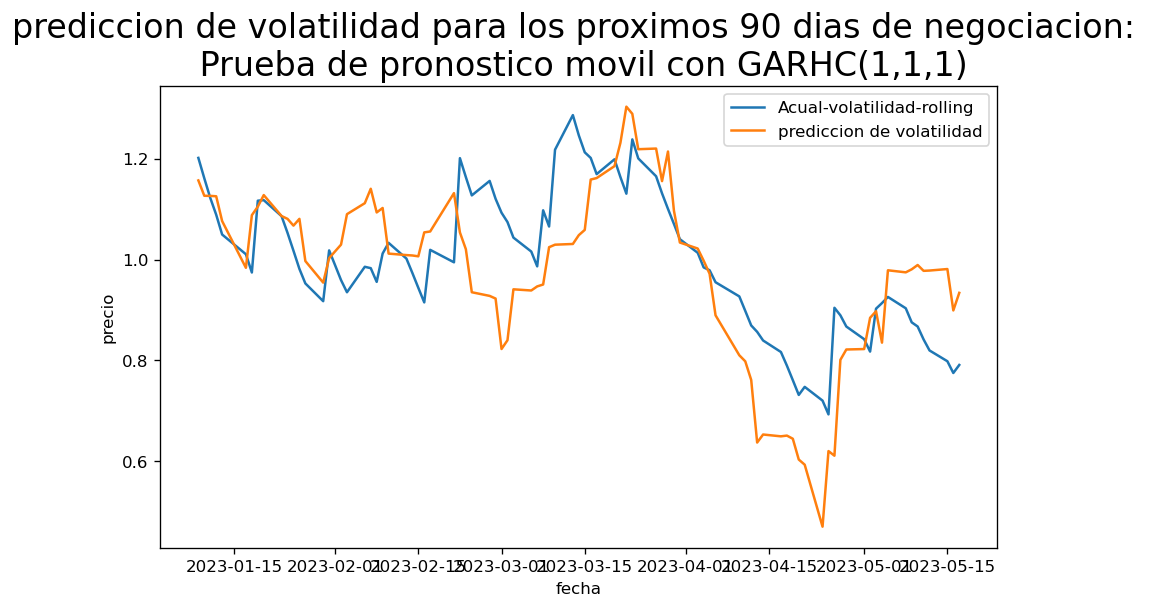

In [124]:
# graficar los datos reales y las predicciones de volatilidad
plt.plot(rolling_pred,label='Acual-volatilidad-rolling')
plt.plot((rolling_vol)[-test_size:],label='prediccion de volatilidad')
plt.title('prediccion de volatilidad para los proximos 90 dias de negociacion: \n Prueba de pronostico movil con GARHC(1,1,1)',fontsize=20)
plt.xlabel('fecha')
plt.ylabel('precio')
plt.legend()
plt.show()


# XGBOOST

XGBoost se basa en el concepto de Gradient Boosting, que es una técnica de ensamblaje que combina varios modelos débiles (normalmente árboles de decisión) para formar un modelo más robusto. El algoritmo entrena los árboles de forma secuencial, enfocándose en los errores residuales de los modelos anteriores

XGBoost es conocido por su excelente rendimiento en términos de precisión y velocidad. Dado que el S&P500 es un índice ampliamente seguido y se negocia activamente en los mercados financieros, la capacidad de predecir los retornos con alta precisión y en tiempo real es fundamental para los inversores y operadores.

In [60]:
df = yf.download(tickers = '^GSPC',start='2021-01-01',end='2023-10-05',interval='1d')
df_ml = df[['Close']]
df_ml.head()

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2021-01-04,3700.649902
2021-01-05,3726.860107
2021-01-06,3748.139893
2021-01-07,3803.790039
2021-01-08,3824.679932


In [125]:
# retornos
df_ml['retornos'] = 100 * df_ml['Close'].pct_change()
df_ml = df_ml.dropna()
df_ml.head()

,Date,Close,retornos,win_22
21,2021-02-04,3871.739990,1.085332,1.053701
22,2021-02-05,3886.830078,0.389750,1.048719
23,2021-02-08,3915.590088,0.739935,1.052205
24,2021-02-09,3911.229980,-0.111352,1.014038
25,2021-02-10,3909.879883,-0.034518,1.010222


In [126]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 21 to 595
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      575 non-null    datetime64[ns]
 1   Close     575 non-null    float64       
 2   retornos  575 non-null    float64       
 3   win_22    575 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 22.5 KB


In [127]:
df_ml.describe()

,Close,retornos,win_22
count,575.000000,575.000000,575.000000
mean,4177.479917,0.021422,1.130228
std,280.636809,1.192677,0.414005
min,3577.030029,-4.323661,0.412746
25%,3955.685059,-0.683404,0.827141
50%,4140.770020,-0.008426,1.080179
75%,4400.455078,0.738334,1.415262
max,4796.560059,5.543448,2.146113


In [128]:
# promedio movil de 22 dias
df_ml['win_22'] = abs(df_ml['retornos'].rolling(window=22,min_periods=22).std().dropna())
df_ml.head(16)

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_6164\1136229054.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,Close,retornos,win_22
21,2021-02-04,3871.739990,1.085332,NaN
22,2021-02-05,3886.830078,0.389750,NaN
23,2021-02-08,3915.590088,0.739935,NaN
24,2021-02-09,3911.229980,-0.111352,NaN
25,2021-02-10,3909.879883,-0.034518,NaN
26,2021-02-11,3916.379883,0.166246,NaN
27,2021-02-12,3934.830078,0.471103,NaN
28,2021-02-16,3932.590088,-0.056927,NaN
29,2021-02-17,3931.330078,-0.032040,NaN
30,2021-02-18,3913.969971,-0.441584,NaN


In [129]:
df_ml.reset_index(inplace=True)

In [130]:
df_ml.info() #la fecha esta en tiempo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     575 non-null    int64         
 1   Date      575 non-null    datetime64[ns]
 2   Close     575 non-null    float64       
 3   retornos  575 non-null    float64       
 4   win_22    554 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 22.6 KB


In [131]:
# renombrar el df
serie_for_xgboost = df_ml
# establecer el tamaño del test
test_size = 90
# dividir el df en train y test
train_ml = serie_for_xgboost[:-(test_size)].dropna()
test_ml = serie_for_xgboost[-(test_size):].dropna()

In [132]:
train_ml.head()

,index,Date,Close,retornos,win_22
21,42,2021-03-08,3821.350098,-0.535923,1.077970
22,43,2021-03-09,3875.439941,1.415464,1.096016
23,44,2021-03-10,3898.810059,0.603031,1.100469
24,45,2021-03-11,3939.340088,1.039549,1.111603
25,46,2021-03-12,3943.340088,0.101540,1.111210


In [133]:
train_ml.shape, test_ml.shape

((464, 5), (90, 5))

In [134]:
# extraer carac para series de tiempo
def create_features(df,label=None):
    '''
    Crear caracteristicas de fecha para el indice datetime
    '''
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day

    X = df[['dayofweek','quarter','month','year','dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X


In [135]:
X_train, y_train = create_features(train_ml, label="win_22")
X_test, y_test = create_features(test_ml, label="win_22")

In [136]:
X_train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth
21,0,1,3,2021,67,8
22,1,1,3,2021,68,9
23,2,1,3,2021,69,10
24,3,1,3,2021,70,11
25,4,1,3,2021,71,12


In [137]:
# crear adicionalmente caracteristicas que usen los 4 dias previos de rolling volatility, incorporando el componente autorregresivo para nuesto modelo de ML
X_train['prev1'] = train_ml['win_22'].shift(1) # shift trae los rezagos
X_test['prev1'] = test_ml['win_22'].shift(1)
X_train['prev2'] = train_ml['win_22'].shift(2)
X_test['prev2'] = test_ml['win_22'].shift(2)
X_train['prev3'] = train_ml['win_22'].shift(3)
X_test['prev3'] = test_ml['win_22'].shift(3)

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_6164\2818475730.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_6164\2818475730.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Juan Guzman\AppData\Local\Temp\ipykernel_6164\2818475730.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [138]:
X_train

,dayofweek,quarter,month,year,dayofyear,dayofmonth,prev1,prev2,prev3
21,0,1,3,2021,67,8,NaN,NaN,NaN
22,1,1,3,2021,68,9,1.077970,NaN,NaN
23,2,1,3,2021,69,10,1.096016,1.077970,NaN
24,3,1,3,2021,70,11,1.100469,1.096016,1.077970
25,4,1,3,2021,71,12,1.111603,1.100469,1.096016
...,...,...,...,...,...,...,...,...,...
480,4,4,12,2022,364,30,1.313085,1.276689,1.260512
481,1,1,1,2023,3,3,1.313358,1.313085,1.276689
482,2,1,1,2023,4,4,1.098603,1.313358,1.313085
483,3,1,1,2023,5,5,1.120351,1.098603,1.313358


## Implementacion modelo XGBOOST

In [139]:
reg = xgb.XGBRFRegressor(n_stimators = 1000)
# entrenamiento del modelo
reg.fit(X_train,y_train,
        eval_set = [(X_train,y_train),(X_test,y_test)],
                    verbose=False)

[17:37:42] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_stimators" } are not used.



XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, n_stimators=1000,
               num_parallel_tree=None, objective='reg:squarederror',
               predictor=None, random_state=None, ...)

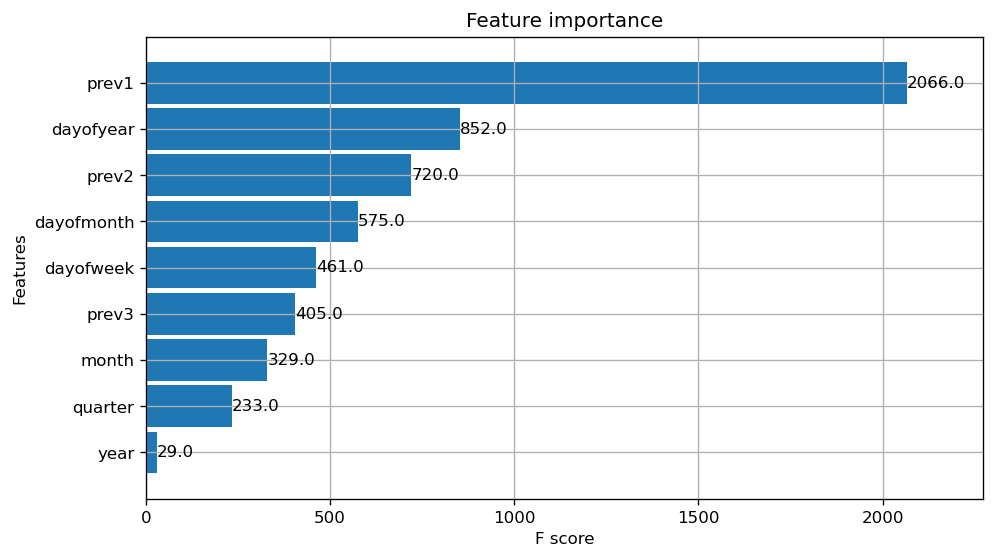

In [141]:
# visualizacion las variables de mas importancia en el modelo
__ = plot_importance(reg,height=0.9)

De la grafica inferimos que el primer rezago, dias del año y dias del mes las variables mas importantes

In [142]:
# realizamos las predicciones para train y test
train_ml['Predictions'] = reg.predict(X_train)
test_ml['Predictions'] = reg.predict(X_test)

In [143]:
# df con pred y real
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml['Predictions']),list(train_ml['win_22']))],axis=1).dropna().reset_index()
# renombramiento de columnas
XGBoost_and_rolling.rename(columns={'index':'Real_volatility',0:"Predicted Volatility"},inplace=True)
XGBoost_and_rolling.head()

,Real_volatility,Predicted Volatility
0,1.077970,1.206030
1,1.096016,1.085122
2,1.100469,1.120592
3,1.111603,1.129398
4,1.111210,1.129032


In [144]:
XGBoost_and_rolling.set_index(train_ml['Date'],inplace=True)

In [145]:
XGBoost_and_rolling = px.line(XGBoost_and_rolling,
                              title="XGBOOST vs rolling volatilidad de los retornos para train")
XGBoost_and_rolling.show()

In [146]:
test_ml.set_index('Date',inplace=True)

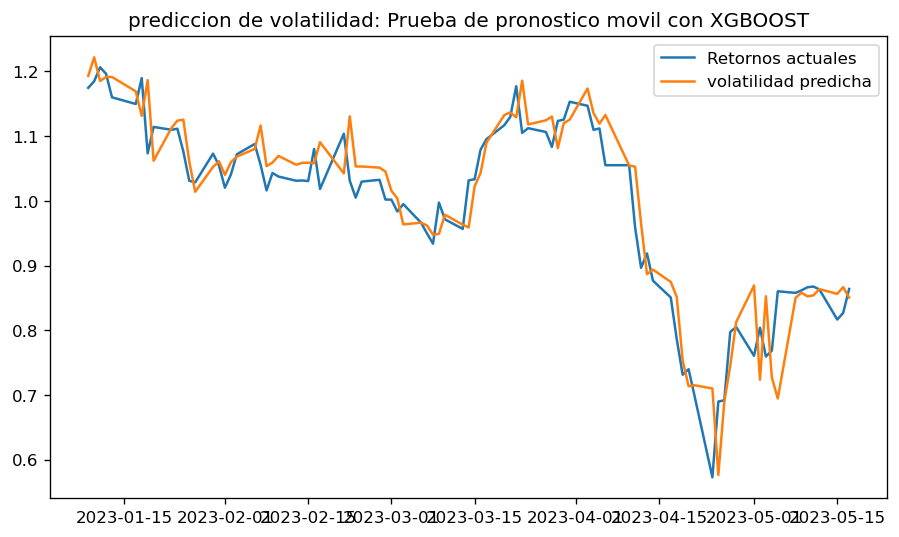

In [147]:
true, = plt.plot(test_ml['win_22'])
preds, = plt.plot(test_ml['Predictions'])
plt.title('prediccion de volatilidad: Prueba de pronostico movil con XGBOOST')
plt.legend(['Retornos actuales','volatilidad predicha'])

# Evaluacion

* Root Mean Squared Error (RMSE):

El RMSE es una métrica comúnmente utilizada para medir la precisión de un modelo de regresión. Se calcula tomando la raíz cuadrada del error cuadrático medio, que a su vez se obtiene promediando los errores cuadrados entre los valores predichos y los valores reales.

El RMSE se expresa en las mismas unidades que la variable objetivo y proporciona una medida de la diferencia promedio entre los valores predichos y los valores reales. Un RMSE más bajo indica una mayor precisión del modelo, ya que implica que los valores predichos se ajustan mejor a los valores reales.

* Mean Absolute Percentage Error (MAPE):

El MAPE es una métrica utilizada para evaluar la precisión de un modelo en términos de porcentaje de error absoluto promedio en relación con los valores reales. Se calcula tomando el promedio de los errores absolutos porcentuales entre los valores predichos y los valores reales, y multiplicándolo por 100 para obtener un porcentaje.

El MAPE proporciona una medida relativa del error promedio en términos porcentuales, lo que permite comparar la precisión entre diferentes modelos y conjuntos de datos. Un MAPE más bajo indica una mayor precisión del modelo, ya que implica que los valores predichos tienen un menor porcentaje de diferencia con respecto a los valores reales.

In [148]:
garch_and_rolling_std

,cond_vol,close
Date,,
2021-01-26,0.716524,0.668991
2021-01-27,0.701155,0.977675
2021-01-28,1.156127,0.998550
2021-01-29,1.118860,1.042418
2021-02-01,1.291980,1.125609
...,...,...
2023-05-11,0.839889,0.977655
2023-05-12,0.819128,0.978227
2023-05-15,0.799003,0.981210


In [149]:
RMSE_serie = mean_squared_error(garch_and_rolling_std['close'],garch_and_rolling_std['cond_vol'],squared=False)
MAPE_serie = mean_absolute_percentage_error(garch_and_rolling_std['close'],garch_and_rolling_std['cond_vol'])
print(f"el RMSE del modelo GARCH en los datos de la serie completa es: {round(RMSE_serie,4)}")
print(f"el MAPE del modelo GARCH en los datos de la serie completa es: {round(MAPE_serie*100,4)}%")

el RMSE del modelo GARCH en los datps de la serie completa es: 0.19
el MAPE del modelo GARCH en los datps de la serie completa es: 15.1887%


In [150]:
true_vol = rolling_vol[-test_size:]
pred_vol = rolling_predictions
RMSE = mean_squared_error(true_vol,pred_vol,squared=False)
MAPE = mean_absolute_percentage_error(true_vol,pred_vol)
print(f"el RMSE del modelo GARCH en los datos predichos es: {round(RMSE,4)}")
print(f"el MAPE del modelo GARCH en los datos predichos es: {round(MAPE*100,4)}%")

el RMSE del modelo GARCH en los datos predichos es: 0.1194
el MAPE del modelo GARCH en los datos predichos es: 10.8636%


In [151]:
RMSE_Serie_XG = mean_squared_error(train_ml['win_22'],train_ml['Predictions'],squared=False)
MAPE_serie_XG = mean_absolute_percentage_error(train_ml['win_22'],train_ml['Predictions'])
print(f"el RMSE del modelo XGBOOST en los datos de la serie completa es: {round(RMSE_Serie_XG,4)}")
print(f"el MAPE del modelo XGBOOST en los datos de la serie completa es: {round(MAPE_serie_XG*100,4)}%")

el RMSE del modelo XGBOOST en los datos de la serie completa es: 0.0342
el MAPE del modelo XGBOOST en los datos de la serie completa es: 2.2963%


In [152]:
true_vol = test_ml['Predictions']
pred_vol = test_ml['win_22']
RMSE_XG=mean_squared_error(true_vol,pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol,pred_vol)
print(f"el RMSE del modelo XGBOOST en los datos pevistos es: {round(RMSE_XG,4)}")
print(f"el MAPE del modelo XGBOOST en los datos pedichos es: {round(MAPE_XG*100,4)}%")

el RMSE del modelo XGBOOST en los datos pevistos es: 0.0481
el MAPE del modelo XGBOOST en los datos pedichos es: 3.7726%
